# **Installation de pytorch geometric et l'initialisation des données**

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
#installation de pytorch geometric selon la version de torch actuelle
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.12.1+cu113
     |████████████████████████████████| 7.9 MB 13.5 MB/s 
     |████████████████████████████████| 3.5 MB 14.2 MB/s 


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric

In [3]:
!pip install ogb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.1 MB/s 
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7048 sha256=20c6a39ff1c5438b093b54a0c0e78c30ee405acd4f57edeb98e6382205041eed
  Stored in directory: /root/.cache/pip/wheels/d6/64/cd/32819b511a488e4993f2fab909a95330289c3f4e0f6ef4676d
Successfully built littleutils


In [4]:
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

In [5]:
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
# on télécharge les données arxiv avec tansformation to sparse tensor pour transformer les edge_index à une matrice d'adjacence
dataset = PygNodePropPredDataset(name = 'ogbn-arxiv',transform=T.ToSparseTensor()) 
# divisement des données en données train validation et test
split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]

Downloaded 0.08 GB: 100%|██████████| 81/81 [00:08<00:00, 10.02it/s]


Extracting dataset/arxiv.zip


Processing...


Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 7319.90it/s]


Converting graphs into PyG objects...


100%|██████████| 1/1 [00:00<00:00, 2585.88it/s]

Saving...



Done!


In [6]:
# define the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [7]:
dataset[0]

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=1166243])

In [8]:
#on envoi les données vers le gpu
data = dataset[0]
data.adj_t = data.adj_t.to_symmetric()
data = data.to(device)
data.adj_t = data.adj_t.to(device)
data.x = data.x.to(device)
data

Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343, nnz=2315598])

# **Développement des Modeles GNN**


#1.   GCN
#2.   GAT
#3.   GSAGE 
#4.   GATSAGE

In [9]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as nn
import torch.nn as nh

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # 3 couches GCNConv de pytorch_geometric et 2 couches lineaire
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels,hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, adj_t):
        #fonction d'activation relu sauf pour l'output c'est log softmax
        # ainsi l'utilisation de dropout pour aider à ne pas avoir du overfitting
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x,adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x)
        return x

modelGCN = GCN(hidden_channels=18)
modelGCN.to(device)

GCN(
  (conv1): GCNConv(128, 18)
  (conv2): GCNConv(18, 18)
  (conv3): GCNConv(18, 18)
  (lin1): Linear(in_features=18, out_features=18, bias=True)
  (lin2): Linear(in_features=18, out_features=40, bias=True)
)

In [10]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        # 3 couches GATConv de pytorch_geometric et 2 couches lineaire
        self.conv1 = GATConv(dataset.num_features, hidden_channels,heads)
        self.conv2 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.conv3 = GATConv(heads*hidden_channels, hidden_channels,heads)
        self.lin1 = torch.nn.Linear(hidden_channels*heads, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)
            

    def forward(self, x, adj_t):
        #fonction d'activation relu sauf pour l'output c'est log softmax
        # ainsi l'utilisation de dropout pour aider à ne pas avoir du overfitting
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x,adj_t)
        x = F.relu(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x)
        return x

modelGAT = GAT(hidden_channels=10, heads=8)
modelGAT = modelGAT.to(device)
modelGAT

GAT(
  (conv1): GATConv(128, 10, heads=8)
  (conv2): GATConv(80, 10, heads=8)
  (conv3): GATConv(80, 10, heads=8)
  (lin1): Linear(in_features=80, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=40, bias=True)
)

In [11]:
from torch_geometric.nn import SAGEConv

class GSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = SAGEConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, adj_t):
        #fonction d'activation relu sauf pour l'output c'est log softmax
        # ainsi l'utilisation de dropout pour aider à ne pas avoir du overfitting
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x,adj_t)
        x = F.relu(x)
        x = self.lin1(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x,dim=1)
        return x

modelSAGE = GSAGE(hidden_channels=30)
modelSAGE = modelSAGE.to(device)
modelSAGE

GSAGE(
  (conv1): SAGEConv(128, 30, aggr=mean)
  (conv2): SAGEConv(30, 30, aggr=mean)
  (conv3): SAGEConv(30, 30, aggr=mean)
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=40, bias=True)
)

In [18]:
from torch_geometric.nn import SAGEConv,GATConv
class GATSAGE(torch.nn.Module):
    def __init__(self,hidden_channels):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, adj_t):
        x = self.conv1(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv2(x, adj_t)
        x = F.relu(x)
        x = F.dropout(x, p=0.4, training=self.training)
        x = self.conv3(x,adj_t)
        x = F.relu(x)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.25, training=self.training)
        x = self.lin2(x)
        x = F.log_softmax(x,dim=1)
        return x

modelGATSAGE = GATSAGE(hidden_channels=30)
modelGATSAGE = modelGATSAGE.to(device)
modelGATSAGE

GATSAGE(
  (conv1): GATConv(128, 30, heads=1)
  (conv2): SAGEConv(30, 30, aggr=mean)
  (conv3): SAGEConv(30, 30, aggr=mean)
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=40, bias=True)
)

# **Fonction Train et Test Générales pour tous les modèles**

In [13]:
#Define train and test
from torch import nn
criterion = torch.nn.CrossEntropyLoss()

def train(model, data, train_idx, optimizer):
    model.train()

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)[train_idx]
    #on utilise squeeze pour que la taille de data.y soit conforme à la taille de out
    loss = criterion(out, data.y.squeeze(1)[train_idx])
    loss.backward()
    optimizer.step()

    return float(loss)




@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()
    
    #pour tester la précision du model on utilise l'evaluator de ogb suivant sa documentation

    out = model(data.x, data.adj_t)
    y_pred = out.argmax(dim=-1, keepdim=True)
    
    train_acc = evaluator.eval({'y_true': data.y[split_idx['train']],
                                'y_pred': y_pred[split_idx['train']],
                               })['acc']
    valid_acc = evaluator.eval({'y_true': data.y[split_idx['valid']],
                                'y_pred': y_pred[split_idx['valid']],
                               })['acc']
    test_acc = evaluator.eval({'y_true': data.y[split_idx['test']],
                               'y_pred': y_pred[split_idx['test']],
                              })['acc']

    return train_acc, valid_acc, test_acc

# **Entraînement et Test des Modèles**

#1.   GCN
#2.   GAT
#3.   GSAGE
#4.   GATSAGE

In [14]:
optimizerGCN = torch.optim.Adam(modelGCN.parameters(), lr=0.01)
epochs = 600
print_steps = 1
evaluator = Evaluator(name='ogbn-arxiv')
losses_GCN = []
train_accuracy_GCN = []
test_accuracy_GCN = []
for epoch in range(1, 1 + epochs):
    loss = train(modelGCN, data, train_idx, optimizerGCN)
    result = test(modelGCN, data, split_idx, evaluator)
    losses_GCN.append(loss)
    train_accuracy_GCN.append(result[0])
    test_accuracy_GCN.append(result[2])
    if epoch % print_steps == 0:
        train_acc, valid_acc, test_acc = result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01, Loss: 3.6670, Train: 4.23%, Valid: 1.48% Test: 0.98%
Epoch: 02, Loss: 3.6293, Train: 11.33%, Valid: 23.06% Test: 21.63%
Epoch: 03, Loss: 3.5872, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 04, Loss: 3.5335, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 05, Loss: 3.4646, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 06, Loss: 3.4002, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 07, Loss: 3.3623, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 08, Loss: 3.3175, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 09, Loss: 3.2655, Train: 17.92%, Valid: 7.63% Test: 5.86%
Epoch: 10, Loss: 3.2259, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 11, Loss: 3.2004, Train: 17.93%, Valid: 7.63% Test: 5.87%
Epoch: 12, Loss: 3.1665, Train: 17.93%, Valid: 7.63% Test: 5.87%
Epoch: 13, Loss: 3.1416, Train: 17.98%, Valid: 7.63% Test: 5.88%
Epoch: 14, Loss: 3.1165, Train: 18.25%, Valid: 7.70% Test: 5.94%
Epoch: 15, Loss: 3.0869, Train: 19.29%, Valid: 8.04% Test: 6.29%
Epoch: 16, L

In [15]:
optimizerGAT = torch.optim.Adam(modelGAT.parameters(), lr=0.01)
epochs = 600
print_steps = 1
evaluator = Evaluator(name='ogbn-arxiv')
losses_GAT = []
train_accuracy_GAT = []
test_accuracy_GAT = []
for epoch in range(1, 1 + epochs):
    loss = train(modelGAT, data, train_idx, optimizerGAT)
    result = test(modelGAT, data, split_idx, evaluator)
    losses_GAT.append(loss)
    train_accuracy_GAT.append(result[0])
    test_accuracy_GAT.append(result[2])
    if epoch % print_steps == 0:
        train_acc, valid_acc, test_acc = result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 01, Loss: 3.7167, Train: 3.23%, Valid: 2.61% Test: 2.56%
Epoch: 02, Loss: 3.6926, Train: 3.23%, Valid: 2.61% Test: 2.56%
Epoch: 03, Loss: 3.6497, Train: 3.23%, Valid: 2.61% Test: 2.56%
Epoch: 04, Loss: 3.5564, Train: 17.96%, Valid: 7.65% Test: 5.93%
Epoch: 05, Loss: 3.4775, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 06, Loss: 3.4136, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 07, Loss: 3.3231, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 08, Loss: 3.2892, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 09, Loss: 3.2602, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 10, Loss: 3.2256, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 11, Loss: 3.1741, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 12, Loss: 3.1187, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 13, Loss: 3.0673, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 14, Loss: 3.0258, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 15, Loss: 2.9900, Train: 17.92%, Valid: 7.64% Test: 5.88%
Epoch: 16, Loss: 2.9615, Tra

In [16]:
optimizerSAGE = torch.optim.Adam(modelSAGE.parameters(), lr=0.01,weight_decay=5e-4)
epochs = 600
print_steps = 1
losses_GSAGE = []
train_accuracy_GSAGE = []
test_accuracy_GSAGE = []
evaluator = Evaluator(name='ogbn-arxiv')
for epoch in range(1, 1 + epochs):
    loss = train(modelSAGE, data, train_idx, optimizerSAGE)
    result = test(modelSAGE, data, split_idx, evaluator)
    losses_GSAGE.append(loss)
    train_accuracy_GSAGE.append(result[0])
    test_accuracy_GSAGE.append(result[2])
    if epoch % print_steps == 0:
        train_acc, valid_acc, test_acc = result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.6460, Train: 17.90%, Valid: 7.63% Test: 5.86%
Epoch: 02, Loss: 3.5730, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 03, Loss: 3.4343, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 04, Loss: 3.2498, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 05, Loss: 3.4662, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 06, Loss: 3.1998, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 07, Loss: 3.1637, Train: 17.99%, Valid: 7.96% Test: 6.11%
Epoch: 08, Loss: 3.2019, Train: 11.31%, Valid: 22.98% Test: 21.68%
Epoch: 09, Loss: 3.2132, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 10, Loss: 3.1975, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 11, Loss: 3.1614, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 12, Loss: 3.1349, Train: 10.99%, Valid: 22.97% Test: 21.56%
Epoch: 13, Loss: 3.1278, Train: 23.90%, Valid: 25.08% Test: 22.15%
Epoch: 14, Loss: 3.1090, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 15, Loss: 3.0844, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 16, Lo

In [19]:
optimizerGATSAGE = torch.optim.Adam(modelGATSAGE.parameters(), lr=0.01)
epochs = 600
print_steps = 1
evaluator = Evaluator(name='ogbn-arxiv')
losses_GATSAGE = []
train_accuracy_GATSAGE = []
test_accuracy_GATSAGE = []
for epoch in range(1, 1 + epochs):
    loss = train(modelGATSAGE, data, train_idx, optimizerGATSAGE)
    result = test(modelGATSAGE, data, split_idx, evaluator)
    losses_GATSAGE.append(loss)
    train_accuracy_GATSAGE.append(result[0])
    test_accuracy_GATSAGE.append(result[2])
    if epoch % print_steps == 0:
        train_acc, valid_acc, test_acc = result
        print(f'Epoch: {epoch:02d}, '
              f'Loss: {loss:.4f}, '
              f'Train: {100 * train_acc:.2f}%, '
              f'Valid: {100 * valid_acc:.2f}% '
              f'Test: {100 * test_acc:.2f}%')

Epoch: 01, Loss: 3.6928, Train: 4.79%, Valid: 8.27% Test: 8.24%
Epoch: 02, Loss: 3.6478, Train: 4.77%, Valid: 9.56% Test: 9.53%
Epoch: 03, Loss: 3.5914, Train: 20.83%, Valid: 15.03% Test: 13.42%
Epoch: 04, Loss: 3.4852, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 05, Loss: 3.3230, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 06, Loss: 3.2377, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 07, Loss: 3.2773, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 08, Loss: 3.1712, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 09, Loss: 3.1255, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 10, Loss: 3.1280, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 11, Loss: 3.1151, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 12, Loss: 3.0846, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 13, Loss: 3.0563, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 14, Loss: 3.0548, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 15, Loss: 3.0320, Train: 17.91%, Valid: 7.63% Test: 5.86%
Epoch: 16, Loss: 2.9946, 

# **Graphes de l'Evaluation des losses, Train Accuracy et Test Accuracy pour tous les Modèles**

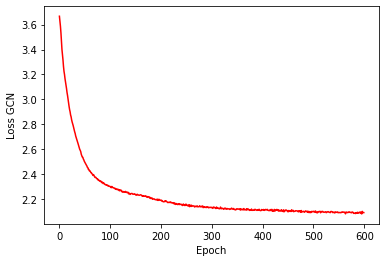

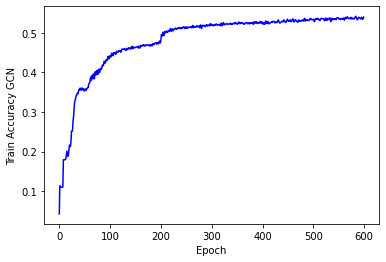

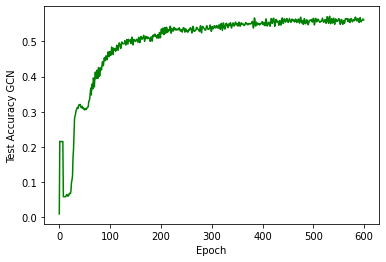

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GCN)), losses_GCN, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GCN')
plt.show()

plt.plot(np.arange(len(train_accuracy_GCN )), train_accuracy_GCN , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GCN')
plt.show()

plt.plot(np.arange(len(test_accuracy_GCN )), test_accuracy_GCN , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GCN')
plt.show()

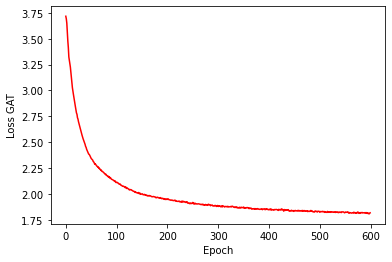

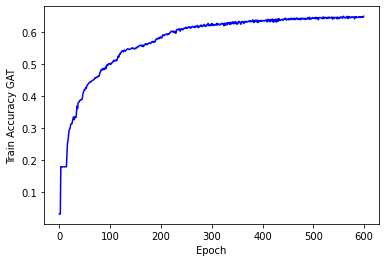

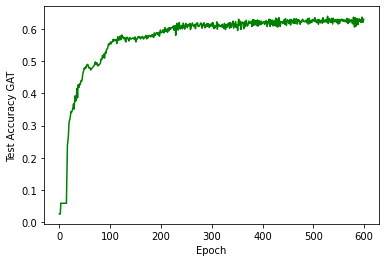

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GAT)), losses_GAT, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GAT')
plt.show()

plt.plot(np.arange(len(train_accuracy_GAT )), train_accuracy_GAT , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GAT')
plt.show()

plt.plot(np.arange(len(test_accuracy_GAT )), test_accuracy_GAT , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GAT')
plt.show()

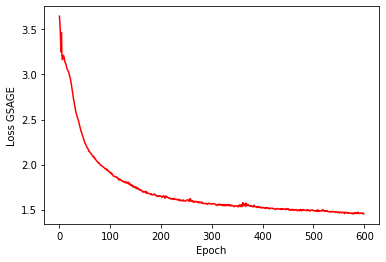

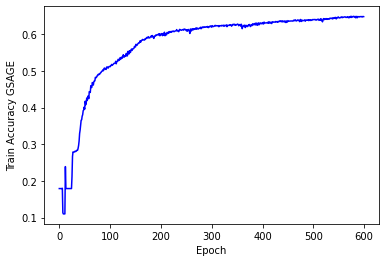

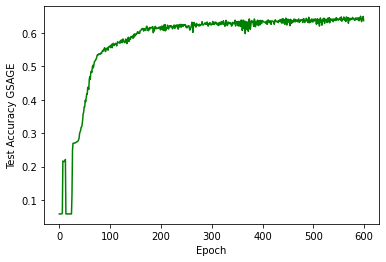

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GSAGE)), losses_GSAGE, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GSAGE')
plt.show()

plt.plot(np.arange(len(train_accuracy_GSAGE )), train_accuracy_GSAGE , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GSAGE')
plt.show()

plt.plot(np.arange(len(test_accuracy_GSAGE )), test_accuracy_GSAGE , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GSAGE')
plt.show()

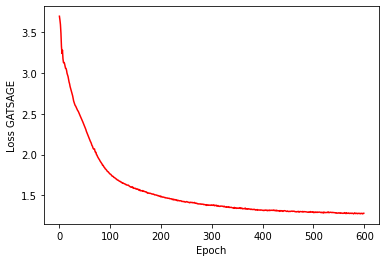

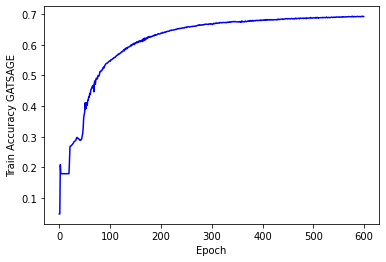

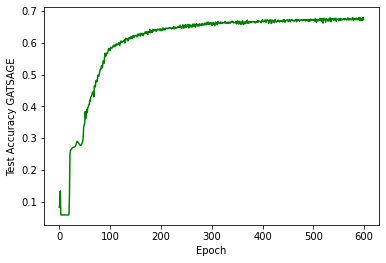

In [23]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(losses_GATSAGE)), losses_GATSAGE, 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss GATSAGE')
plt.show()

plt.plot(np.arange(len(train_accuracy_GATSAGE )), train_accuracy_GATSAGE , 'b')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy GATSAGE')
plt.show()

plt.plot(np.arange(len(test_accuracy_GATSAGE )), test_accuracy_GATSAGE , 'g')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy GATSAGE')
plt.show()